## Provide list of paths for edits and run trials -> (maybe analyze results and add to CSV)

In [1]:
# General imports
import torch
import numpy as np
import os, sys
import json
from tqdm import tqdm
from datetime import datetime
import pandas as pd

In [11]:
# Local imports
sys.path.insert(0, 'src')
from utils import read_json, read_lists, informal_log, list_to_dict, write_lists, write_json
from utils.model_utils import prepare_device
from parse_config import ConfigParser
# from data_loader import data_loaders
import datasets.datasets as module_data
import model.model as module_arch
from utils.knn_utils import load_and_analyze_knn
from utils.results_to_csv import combine_results
from edit_knn import main as edit

In [3]:
# Obtain timestamp
timestamp = datetime.now().strftime(r'%m%d_%H%M%S')
timestamp = '0120_155829'

In [4]:
# Define constants, paths
config_path = 'configs/copies/cinic10_imagenet_segmentation_edit_trials.json'
class_list_path = 'metadata/cinic-10/class_names.txt'
# key_image_id = 'dog-train-n02114712_211'
target_class_name = 'cat'

analyze_in_edit = True
# paths_dir = os.path.join('paths', 'edits', key_image_id)
# paths_dir = os.path.join('paths', 'edits', target_class_name, '0113_120339')
paths_dir = os.path.join('paths', 'edits', 'semantics', target_class_name, '0120_144821')

# key_image_paths = read_lists(os.path.join(paths_dir, 'key_images.txt'))
# value_image_paths = read_lists(os.path.join(paths_dir, 'value_images.txt'))
sort_type = 'logits'
key_image_paths = read_lists(os.path.join(paths_dir, 'key_images_{}.txt'.format(sort_type)))
value_image_paths = read_lists(os.path.join(paths_dir, 'value_images_{}.txt'.format(sort_type)))
n_trials = len(value_image_paths)
assert len(key_image_paths) == n_trials

print("{} edit image pairs".format(n_trials))
print("First key image path: {}".format(key_image_paths[0]))
print("First value image path: {}".format(value_image_paths[0]))

105 edit image pairs
First key image path: data/cinic-10-imagenet/train/cat/n02123242_6867.png
First value image path: saved/segmentations/semantics/cat_20/cat-train-n02123242_6867/felzenszwalb_masked/felzenszwalb_masked_logits.png


In [5]:
# Load config file
config_dict = read_json(config_path)
# Load class list and obtain target class idx
class_list = read_lists(class_list_path)
class_idx_dict = list_to_dict(class_list)
target_class_idx = class_idx_dict[target_class_name]

# Set K
K = config_dict['editor']['K']

device, device_ids = prepare_device(config_dict['n_gpu'])

In [6]:
# Load datasets
data_loader_args = dict(config_dict["data_loader"]["args"])
dataset_args = dict(config_dict["dataset_args"])

# Create validation data loader
val_image_paths = read_lists(config_dict['dataset_paths']['valid_images'])
val_labels = read_lists(config_dict['dataset_paths']['valid_labels'])
val_paths_data_loader = torch.utils.data.DataLoader(
    module_data.CINIC10Dataset(
        data_dir="",
        image_paths=val_image_paths,
        labels=val_labels,
        return_paths=True,
        **dataset_args
    ),
    **data_loader_args
)

# Create data loader for covariance matrix
covariance_image_paths = read_lists(config_dict['covariance_dataset']['images'])
covariance_labels = read_lists(config_dict['covariance_dataset']['labels'])

covariance_data_loader = torch.utils.data.DataLoader(
    module_data.CINIC10Dataset(
        data_dir="",
        image_paths=covariance_image_paths,
        labels=covariance_labels,
        **dataset_args
    ),
    **data_loader_args
)

### Create log and save paths

In [7]:
# create log path to store the paths to each trial
save_root = config_dict['trainer']['save_dir']
save_trials_path = os.path.join(save_root, config_dict['name'], timestamp, 'trial_paths.txt')
progress_report_path = os.path.join(save_root, config_dict['name'], timestamp, 'progress_report.txt')
if os.path.exists(save_trials_path):
    # os.remove(save_trials_path)
    print("Path {} already exists. Aborting.".format(save_trials_path))
else:
    # progress_report_path = os.path.join(save_root, config_dict['name'], timestamp, 'progress_report.txt')
    if os.path.exists(progress_report_path):
        os.remove(progress_report_path)
    print("Saving path to directories for each trial to {}".format(save_trials_path))
    print("Printing progress reports to {}".format(progress_report_path))

Path saved/edit/trials/CINIC10_ImageNet-VGG_16/0120_155829/trial_paths.txt already exists. Aborting.


In [13]:
temp = ['hi' for i in range(100)]
file = 'temp/temp.txt'
write_lists(file, temp)
write_json(config_dict, file)

### Ensure all paths for keys and values exist

In [8]:
non_existent_key_paths = []
non_existent_value_paths = []
for key_path, value_path in zip(key_image_paths, value_image_paths):
    if not os.path.exists(key_path):
        non_existent_key_paths.append(key_path)
    if not os.path.exists(value_path):
        non_existent_value_paths.append(value_path)

if len(non_existent_key_paths) > 0:
    raise ValueError("Following paths are non existent: {}".format(non_existent_key_paths))
    
if len(non_existent_value_paths) > 0:
    raise ValueError("Following paths are non existent: {}".format(non_existent_value_paths))
    

## Run edit for each modified image

(0123_094756) Starting Trial 94/105...
Current run_id: 0120_155829/results/cat-train-n02128757_19470/watershed_masked_logits
saved/edit/trials/CINIC10_ImageNet-VGG_16/0120_155829/results/cat-train-n02128757_19470/watershed_masked_logits
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: data/cinic-10-imagenet/train/cat/n02128757_19470.png
Value images: saved/segmentations/semantics/cat_20/cat-train-n02128757_19470/watershed_masked/watershed_masked_logits.png
Masks: None
Prepared data for editing
Performing pre-edit metric & KNN calculations on validation set.


100%|█████████████████████████████████████████| 274/274 [00:07<00:00, 38.31it/s]


Pre-edit metrics: {'TP': array([6142, 5382, 5203, 3842, 4270, 2990, 5659, 5136, 4820, 4679]), 'TN': array([60115, 61110, 59441, 59902, 60157, 61756, 61050, 61747, 61643,
       61202]), 'FPs': array([2885, 1890, 3559, 3098, 2843, 1244, 1950, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1797, 3158, 2730, 4010, 1341, 1864, 2180, 2321]), 'accuracy': 0.6874714285714286, 'per_class_accuracy': array([0.94652857, 0.94988571, 0.92348571, 0.91062857, 0.92038571,
       0.92494286, 0.95298571, 0.95547143, 0.94947143, 0.94115714]), 'per_class_accuracy_mean': 0.9374942857142857, 'precision': array([0.68040323, 0.74009901, 0.5938142 , 0.55360231, 0.60030929,
       0.706188  , 0.74372454, 0.80388167, 0.78031407, 0.72240235]), 'precision_mean': 0.6924738665961387, 'recall': array([0.87742857, 0.76885714, 0.74328571, 0.54885714, 0.61      ,
       0.42714286, 0.80842857, 0.73371429, 0.68857143, 0.66842857]), 'recall_mean': 0.6874714285714286, 'predicted_class_distribution': array([9027, 7272, 8762, 

tensor(0.0255, device='cuda:0', grad_fn=<DivBackward0>): 100%|█| 40000/40000 [00

Loss (orig, final): 0.18394076824188232 0.025543350726366043
L2 norm of weight change: 0.5166750550270081
Performing post-edit metric & KNN calculations on validation set.



100%|█████████████████████████████████████████| 274/274 [00:09<00:00, 29.02it/s]
/n/fs/ac-editing/model-editing/src/model/metric.py:168: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(TPs / (TPs + FPs))
/n/fs/ac-editing/model-editing/src/model/metric.py:205: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(2 * precisions * recalls / (precisions + recalls))


Post-edit metrics: {'TP': array([6174, 5076, 5398, 4834, 3913, 2952,    0, 5178, 4834, 4726]), 'TN': array([59833, 61571, 58571, 52899, 60861, 61743, 63000, 61674, 61597,
       61336]), 'FPs': array([ 3167,  1429,  4429, 10101,  2139,  1257,     0,  1326,  1403,
        1664]), 'FNs': array([ 826, 1924, 1602, 2166, 3087, 4048, 7000, 1822, 2166, 2274]), 'accuracy': 0.6155, 'per_class_accuracy': array([0.94295714, 0.9521    , 0.91384286, 0.82475714, 0.92534286,
       0.92421429, 0.9       , 0.95502857, 0.94901429, 0.94374286]), 'per_class_accuracy_mean': 0.9231, 'precision': array([0.66095707, 0.78032283, 0.54930294, 0.32366923, 0.64656312,
       0.70135424, 0.        , 0.79612546, 0.77505211, 0.73959311]), 'precision_mean': 0.597294011821573, 'recall': array([0.882     , 0.72514286, 0.77114286, 0.69057143, 0.559     ,
       0.42171429, 0.        , 0.73971429, 0.69057143, 0.67514286]), 'recall_mean': 0.6155, 'predicted_class_distribution': array([ 9341,  6505,  9827, 14935,  6052,  4

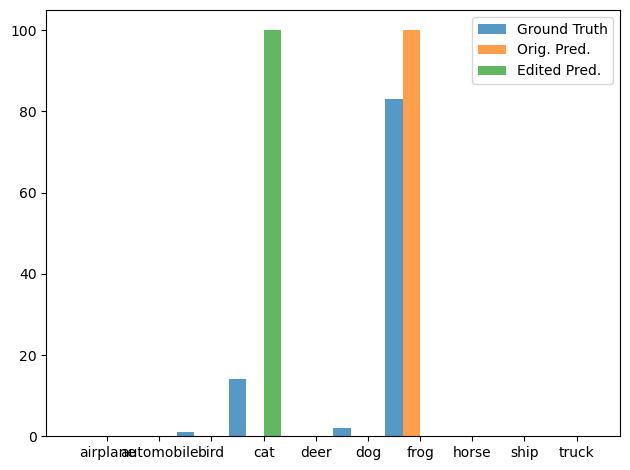

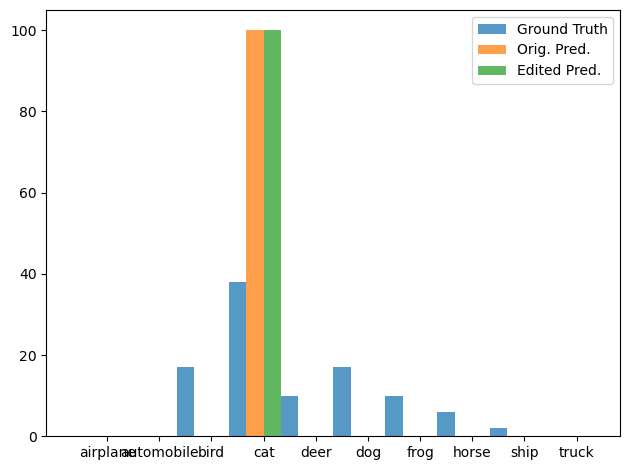

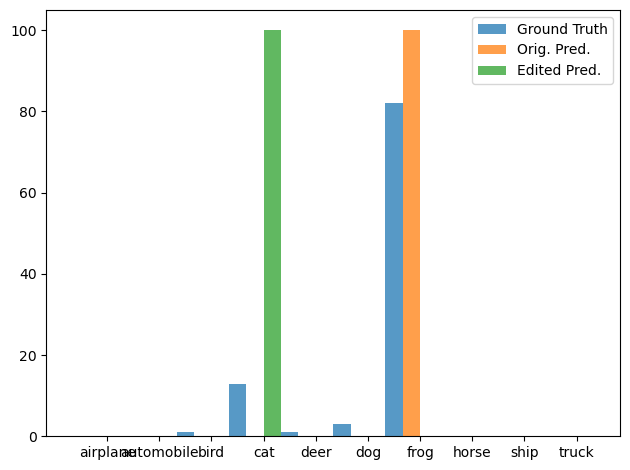

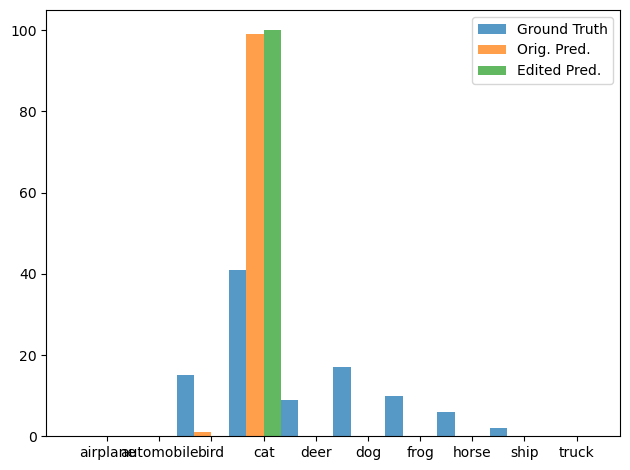

Saved KNN analysis results to saved/edit/trials/CINIC10_ImageNet-VGG_16/0120_155829/results/cat-train-n02128757_19470/watershed_masked_logits/models/knn_analysis_results.pth

All metrics and KNN results can be found in saved/edit/trials/CINIC10_ImageNet-VGG_16/0120_155829/results/cat-train-n02128757_19470/watershed_masked_logits/models
Finished trial 94/105. Results saved to saved/edit/trials/CINIC10_ImageNet-VGG_16/0120_155829/results/cat-train-n02128757_19470/watershed_masked_logits
(0123_094857) Starting Trial 95/105...
Current run_id: 0120_155829/results/cat-train-n02128925_31996/felzenszwalb_masked_logits
saved/edit/trials/CINIC10_ImageNet-VGG_16/0120_155829/results/cat-train-n02128925_31996/felzenszwalb_masked_logits
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: data/cinic-10-imagenet/tra

100%|█████████████████████████████████████████| 274/274 [00:09<00:00, 30.42it/s]


Pre-edit metrics: {'TP': array([6142, 5382, 5203, 3842, 4270, 2990, 5659, 5136, 4820, 4679]), 'TN': array([60115, 61110, 59441, 59902, 60157, 61756, 61050, 61747, 61643,
       61202]), 'FPs': array([2885, 1890, 3559, 3098, 2843, 1244, 1950, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1797, 3158, 2730, 4010, 1341, 1864, 2180, 2321]), 'accuracy': 0.6874714285714286, 'per_class_accuracy': array([0.94652857, 0.94988571, 0.92348571, 0.91062857, 0.92038571,
       0.92494286, 0.95298571, 0.95547143, 0.94947143, 0.94115714]), 'per_class_accuracy_mean': 0.9374942857142857, 'precision': array([0.68040323, 0.74009901, 0.5938142 , 0.55360231, 0.60030929,
       0.706188  , 0.74372454, 0.80388167, 0.78031407, 0.72240235]), 'precision_mean': 0.6924738665961387, 'recall': array([0.87742857, 0.76885714, 0.74328571, 0.54885714, 0.61      ,
       0.42714286, 0.80842857, 0.73371429, 0.68857143, 0.66842857]), 'recall_mean': 0.6874714285714286, 'predicted_class_distribution': array([9027, 7272, 8762, 

tensor(0.0128, device='cuda:0', grad_fn=<DivBackward0>): 100%|█| 40000/40000 [00

Loss (orig, final): 0.1342618316411972 0.01279708743095398
L2 norm of weight change: 0.5429167151451111
Performing post-edit metric & KNN calculations on validation set.



100%|█████████████████████████████████████████| 274/274 [00:10<00:00, 26.03it/s]
/n/fs/ac-editing/model-editing/src/model/metric.py:168: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(TPs / (TPs + FPs))
/n/fs/ac-editing/model-editing/src/model/metric.py:205: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(2 * precisions * recalls / (precisions + recalls))


Post-edit metrics: {'TP': array([6320, 5104, 4125, 5953, 2992, 2820,    0, 5083, 4615, 4841]), 'TN': array([59047, 61529, 61836, 47481, 62187, 61902, 63000, 61813, 61925,
       61133]), 'FPs': array([ 3953,  1471,  1164, 15519,   813,  1098,     0,  1187,  1075,
        1867]), 'FNs': array([ 680, 1896, 2875, 1047, 4008, 4180, 7000, 1917, 2385, 2159]), 'accuracy': 0.5979, 'per_class_accuracy': array([0.93381429, 0.9519    , 0.9423    , 0.76334286, 0.93112857,
       0.9246    , 0.9       , 0.95565714, 0.95057143, 0.94248571]), 'per_class_accuracy_mean': 0.9195800000000001, 'precision': array([0.61520491, 0.77627376, 0.77992059, 0.27724478, 0.78633377,
       0.71975498, 0.        , 0.81068581, 0.81107206, 0.72167561]), 'precision_mean': 0.6298166265385926, 'recall': array([0.90285714, 0.72914286, 0.58928571, 0.85042857, 0.42742857,
       0.40285714, 0.        , 0.72614286, 0.65928571, 0.69157143]), 'recall_mean': 0.5978999999999999, 'predicted_class_distribution': array([10273,  6575

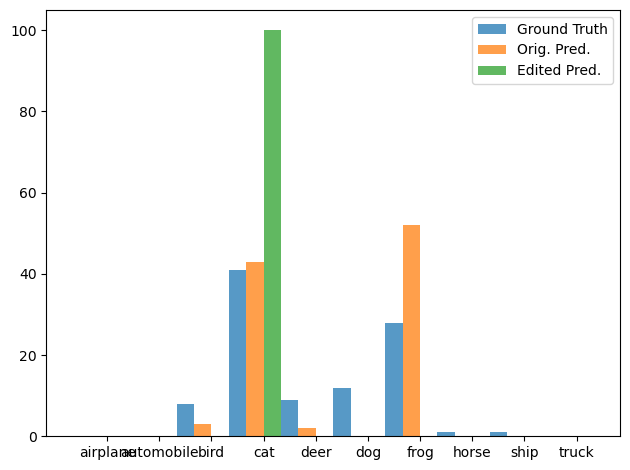

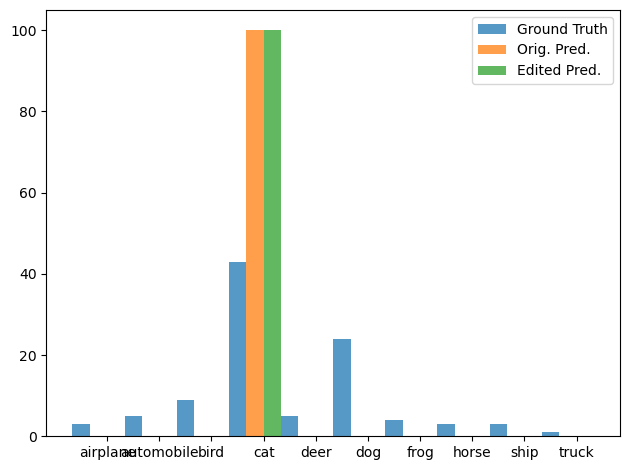

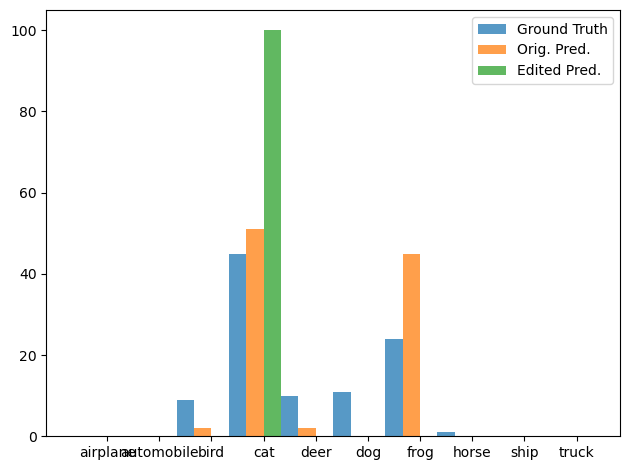

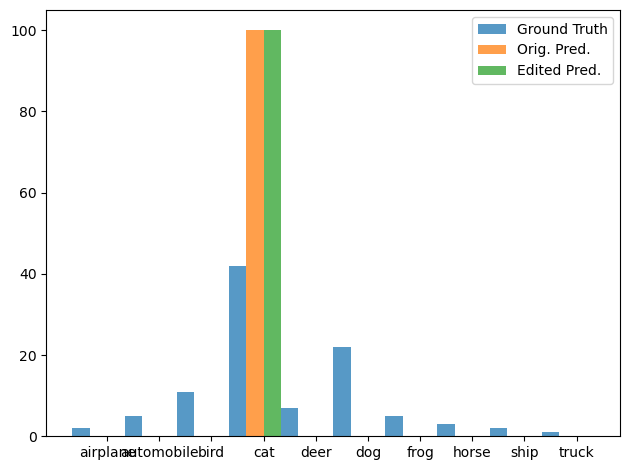

Saved KNN analysis results to saved/edit/trials/CINIC10_ImageNet-VGG_16/0120_155829/results/cat-train-n02128925_31996/felzenszwalb_masked_logits/models/knn_analysis_results.pth

All metrics and KNN results can be found in saved/edit/trials/CINIC10_ImageNet-VGG_16/0120_155829/results/cat-train-n02128925_31996/felzenszwalb_masked_logits/models
Finished trial 95/105. Results saved to saved/edit/trials/CINIC10_ImageNet-VGG_16/0120_155829/results/cat-train-n02128925_31996/felzenszwalb_masked_logits
(0123_095003) Starting Trial 96/105...
Current run_id: 0120_155829/results/cat-train-n02128925_31996/felzenszwalb_gaussian_logits
saved/edit/trials/CINIC10_ImageNet-VGG_16/0120_155829/results/cat-train-n02128925_31996/felzenszwalb_gaussian_logits
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: data/cinic-10

100%|█████████████████████████████████████████| 274/274 [00:09<00:00, 29.56it/s]


Pre-edit metrics: {'TP': array([6142, 5382, 5203, 3842, 4270, 2990, 5659, 5136, 4820, 4679]), 'TN': array([60115, 61110, 59441, 59902, 60157, 61756, 61050, 61747, 61643,
       61202]), 'FPs': array([2885, 1890, 3559, 3098, 2843, 1244, 1950, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1797, 3158, 2730, 4010, 1341, 1864, 2180, 2321]), 'accuracy': 0.6874714285714286, 'per_class_accuracy': array([0.94652857, 0.94988571, 0.92348571, 0.91062857, 0.92038571,
       0.92494286, 0.95298571, 0.95547143, 0.94947143, 0.94115714]), 'per_class_accuracy_mean': 0.9374942857142857, 'precision': array([0.68040323, 0.74009901, 0.5938142 , 0.55360231, 0.60030929,
       0.706188  , 0.74372454, 0.80388167, 0.78031407, 0.72240235]), 'precision_mean': 0.6924738665961387, 'recall': array([0.87742857, 0.76885714, 0.74328571, 0.54885714, 0.61      ,
       0.42714286, 0.80842857, 0.73371429, 0.68857143, 0.66842857]), 'recall_mean': 0.6874714285714286, 'predicted_class_distribution': array([9027, 7272, 8762, 

tensor(0.0030, device='cuda:0', grad_fn=<DivBackward0>): 100%|█| 40000/40000 [00


Loss (orig, final): 0.04378862679004669 0.0030475552193820477
L2 norm of weight change: 0.1689804494380951
Performing post-edit metric & KNN calculations on validation set.


100%|█████████████████████████████████████████| 274/274 [00:10<00:00, 26.72it/s]


Post-edit metrics: {'TP': array([6157, 5276, 5190, 4368, 4057, 2968, 5362, 5150, 4795, 4711]), 'TN': array([60055, 61304, 59465, 58485, 60584, 61743, 61686, 61754, 61688,
       61270]), 'FPs': array([2945, 1696, 3535, 4515, 2416, 1257, 1314, 1246, 1312, 1730]), 'FNs': array([ 843, 1724, 1810, 2632, 2943, 4032, 1638, 1850, 2205, 2289]), 'accuracy': 0.6862, 'per_class_accuracy': array([0.94588571, 0.95114286, 0.92364286, 0.8979    , 0.92344286,
       0.92444286, 0.95782857, 0.95577143, 0.94975714, 0.94258571]), 'per_class_accuracy_mean': 0.9372400000000001, 'precision': array([0.67644474, 0.75674125, 0.59484241, 0.49172577, 0.6267573 ,
       0.70248521, 0.80317555, 0.80519074, 0.78516457, 0.73140817]), 'precision_mean': 0.6973935700114374, 'recall': array([0.87957143, 0.75371429, 0.74142857, 0.624     , 0.57957143,
       0.424     , 0.766     , 0.73571429, 0.685     , 0.673     ]), 'recall_mean': 0.6862, 'predicted_class_distribution': array([9102, 6972, 8725, 8883, 6473, 4225, 6676,

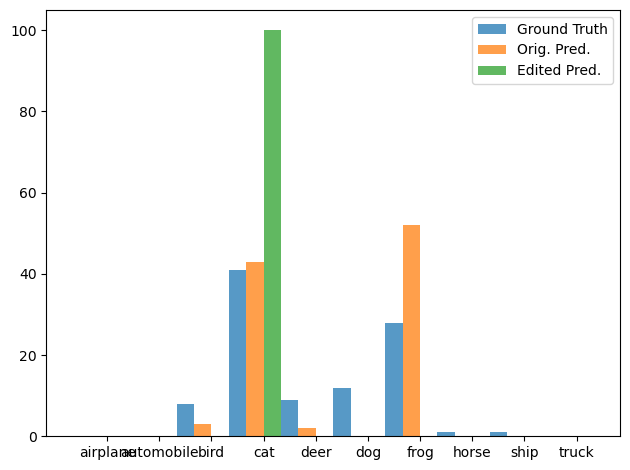

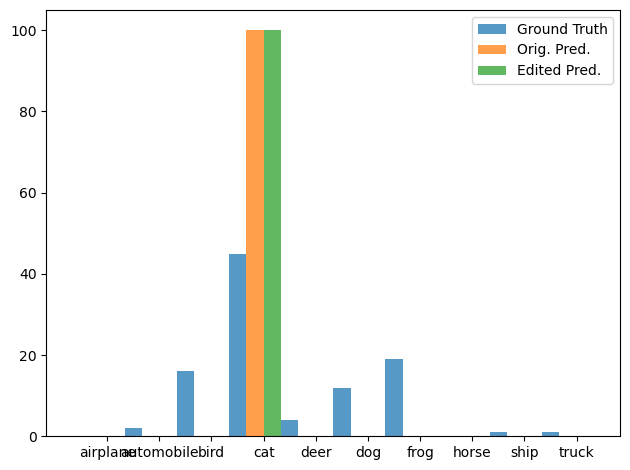

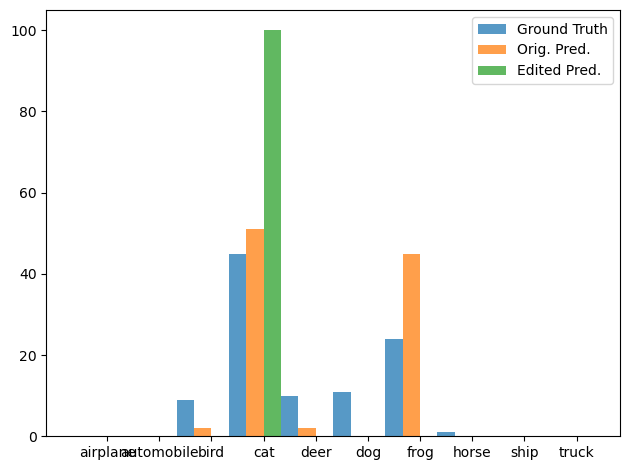

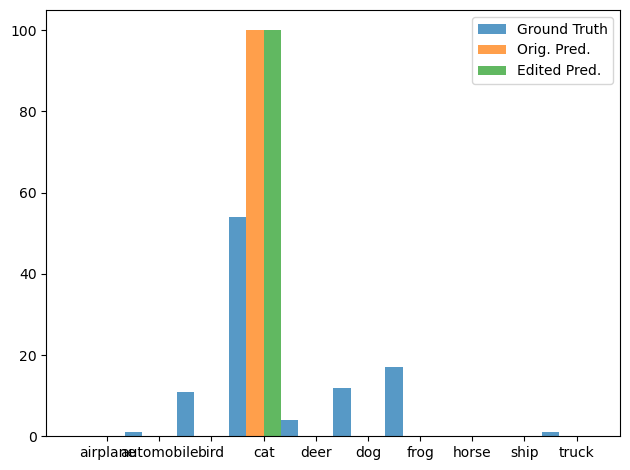

Saved KNN analysis results to saved/edit/trials/CINIC10_ImageNet-VGG_16/0120_155829/results/cat-train-n02128925_31996/felzenszwalb_gaussian_logits/models/knn_analysis_results.pth

All metrics and KNN results can be found in saved/edit/trials/CINIC10_ImageNet-VGG_16/0120_155829/results/cat-train-n02128925_31996/felzenszwalb_gaussian_logits/models
Finished trial 96/105. Results saved to saved/edit/trials/CINIC10_ImageNet-VGG_16/0120_155829/results/cat-train-n02128925_31996/felzenszwalb_gaussian_logits
(0123_095109) Starting Trial 97/105...
Current run_id: 0120_155829/results/cat-train-n02128925_31996/quickshift_masked_logits
saved/edit/trials/CINIC10_ImageNet-VGG_16/0120_155829/results/cat-train-n02128925_31996/quickshift_masked_logits
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: data/cinic-10-i

100%|█████████████████████████████████████████| 274/274 [00:09<00:00, 29.81it/s]


Pre-edit metrics: {'TP': array([6142, 5382, 5203, 3842, 4270, 2990, 5659, 5136, 4820, 4679]), 'TN': array([60115, 61110, 59441, 59902, 60157, 61756, 61050, 61747, 61643,
       61202]), 'FPs': array([2885, 1890, 3559, 3098, 2843, 1244, 1950, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1797, 3158, 2730, 4010, 1341, 1864, 2180, 2321]), 'accuracy': 0.6874714285714286, 'per_class_accuracy': array([0.94652857, 0.94988571, 0.92348571, 0.91062857, 0.92038571,
       0.92494286, 0.95298571, 0.95547143, 0.94947143, 0.94115714]), 'per_class_accuracy_mean': 0.9374942857142857, 'precision': array([0.68040323, 0.74009901, 0.5938142 , 0.55360231, 0.60030929,
       0.706188  , 0.74372454, 0.80388167, 0.78031407, 0.72240235]), 'precision_mean': 0.6924738665961387, 'recall': array([0.87742857, 0.76885714, 0.74328571, 0.54885714, 0.61      ,
       0.42714286, 0.80842857, 0.73371429, 0.68857143, 0.66842857]), 'recall_mean': 0.6874714285714286, 'predicted_class_distribution': array([9027, 7272, 8762, 

tensor(0.0036, device='cuda:0', grad_fn=<DivBackward0>): 100%|█| 40000/40000 [00

Loss (orig, final): 0.037228044122457504 0.0035908964928239584
L2 norm of weight change: 0.21647274494171143
Performing post-edit metric & KNN calculations on validation set.



100%|█████████████████████████████████████████| 274/274 [00:10<00:00, 26.86it/s]


Post-edit metrics: {'TP': array([6146, 5381, 5319, 4140, 3690, 2991, 5700, 5074, 4697, 4724]), 'TN': array([60047, 61115, 58926, 59032, 61306, 61758, 60876, 61875, 61784,
       61143]), 'FPs': array([2953, 1885, 4074, 3968, 1694, 1242, 2124, 1125, 1216, 1857]), 'FNs': array([ 854, 1619, 1681, 2860, 3310, 4009, 1300, 1926, 2303, 2276]), 'accuracy': 0.6837428571428571, 'per_class_accuracy': array([0.94561429, 0.94994286, 0.91778571, 0.90245714, 0.92851429,
       0.92498571, 0.95108571, 0.95641429, 0.94972857, 0.94095714]), 'per_class_accuracy_mean': 0.9367485714285714, 'precision': array([0.67545884, 0.74057253, 0.56627276, 0.51060681, 0.68536404,
       0.70659107, 0.72852761, 0.81851912, 0.79435143, 0.71782404]), 'precision_mean': 0.6944088238690144, 'recall': array([0.878     , 0.76871429, 0.75985714, 0.59142857, 0.52714286,
       0.42728571, 0.81428571, 0.72485714, 0.671     , 0.67485714]), 'recall_mean': 0.6837428571428571, 'predicted_class_distribution': array([9099, 7266, 9393,

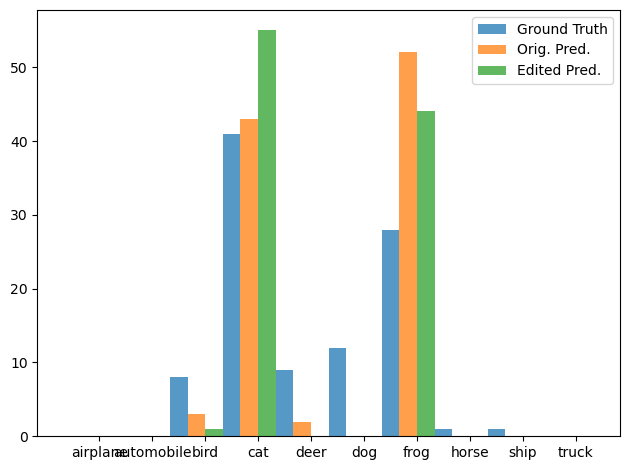

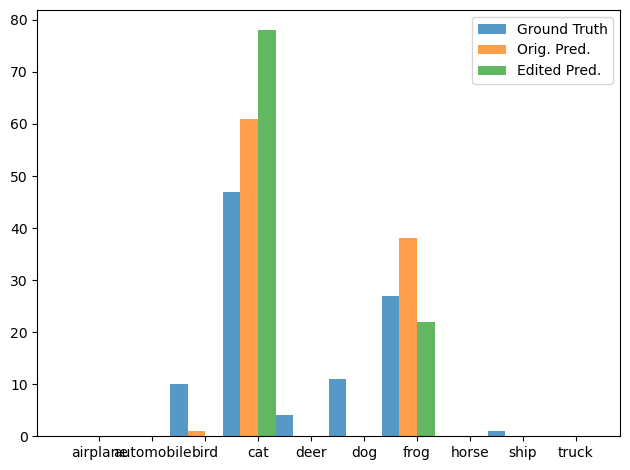

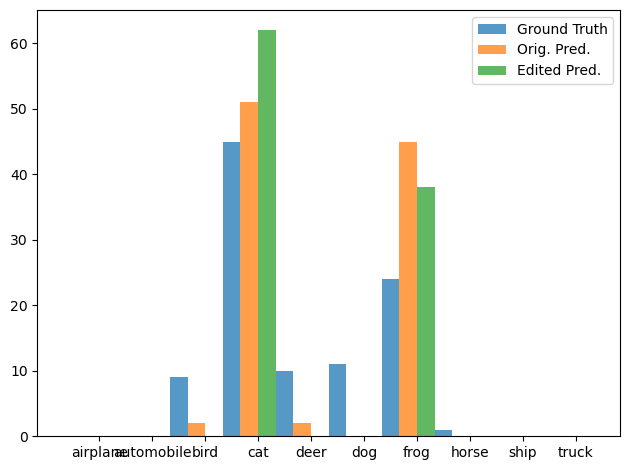

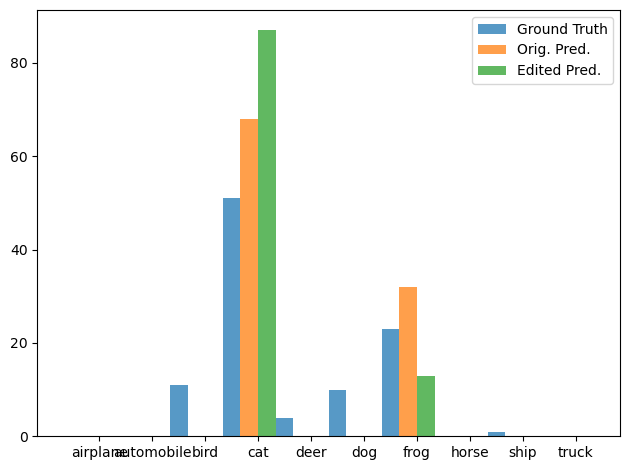

Saved KNN analysis results to saved/edit/trials/CINIC10_ImageNet-VGG_16/0120_155829/results/cat-train-n02128925_31996/quickshift_masked_logits/models/knn_analysis_results.pth

All metrics and KNN results can be found in saved/edit/trials/CINIC10_ImageNet-VGG_16/0120_155829/results/cat-train-n02128925_31996/quickshift_masked_logits/models
Finished trial 97/105. Results saved to saved/edit/trials/CINIC10_ImageNet-VGG_16/0120_155829/results/cat-train-n02128925_31996/quickshift_masked_logits
(0123_095215) Starting Trial 98/105...
Current run_id: 0120_155829/results/cat-train-n02128925_31996/slic_masked_logits
saved/edit/trials/CINIC10_ImageNet-VGG_16/0120_155829/results/cat-train-n02128925_31996/slic_masked_logits
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: data/cinic-10-imagenet/train/cat/n02128

100%|█████████████████████████████████████████| 274/274 [00:09<00:00, 29.42it/s]


Pre-edit metrics: {'TP': array([6142, 5382, 5203, 3842, 4270, 2990, 5659, 5136, 4820, 4679]), 'TN': array([60115, 61110, 59441, 59902, 60157, 61756, 61050, 61747, 61643,
       61202]), 'FPs': array([2885, 1890, 3559, 3098, 2843, 1244, 1950, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1797, 3158, 2730, 4010, 1341, 1864, 2180, 2321]), 'accuracy': 0.6874714285714286, 'per_class_accuracy': array([0.94652857, 0.94988571, 0.92348571, 0.91062857, 0.92038571,
       0.92494286, 0.95298571, 0.95547143, 0.94947143, 0.94115714]), 'per_class_accuracy_mean': 0.9374942857142857, 'precision': array([0.68040323, 0.74009901, 0.5938142 , 0.55360231, 0.60030929,
       0.706188  , 0.74372454, 0.80388167, 0.78031407, 0.72240235]), 'precision_mean': 0.6924738665961387, 'recall': array([0.87742857, 0.76885714, 0.74328571, 0.54885714, 0.61      ,
       0.42714286, 0.80842857, 0.73371429, 0.68857143, 0.66842857]), 'recall_mean': 0.6874714285714286, 'predicted_class_distribution': array([9027, 7272, 8762, 

tensor(0.0036, device='cuda:0', grad_fn=<DivBackward0>): 100%|█| 40000/40000 [00

Loss (orig, final): 0.14043593406677246 0.0036212042905390263
L2 norm of weight change: 0.5606411695480347
Performing post-edit metric & KNN calculations on validation set.



100%|█████████████████████████████████████████| 274/274 [00:10<00:00, 25.64it/s]


Post-edit metrics: {'TP': array([6196, 5027, 3627, 6378, 1118, 2734,    1, 4901, 4497, 4939]), 'TN': array([60178, 61617, 62375, 42144, 62939, 61988, 63000, 62091, 62074,
       61012]), 'FPs': array([ 2822,  1383,   625, 20856,    61,  1012,     0,   909,   926,
        1988]), 'FNs': array([ 804, 1973, 3373,  622, 5882, 4266, 6999, 2099, 2503, 2061]), 'accuracy': 0.5631142857142857, 'per_class_accuracy': array([0.9482    , 0.95205714, 0.94288571, 0.69317143, 0.9151    ,
       0.9246    , 0.90001429, 0.95702857, 0.95101429, 0.94215714]), 'per_class_accuracy_mean': 0.9126228571428572, 'precision': array([0.6870703 , 0.78424337, 0.85301035, 0.23419255, 0.94826124,
       0.72984517, 1.        , 0.84354561, 0.8292458 , 0.71300707]), 'precision_mean': 0.7622421471275719, 'recall': array([8.85142857e-01, 7.18142857e-01, 5.18142857e-01, 9.11142857e-01,
       1.59714286e-01, 3.90571429e-01, 1.42857143e-04, 7.00142857e-01,
       6.42428571e-01, 7.05571429e-01]), 'recall_mean': 0.5631142857

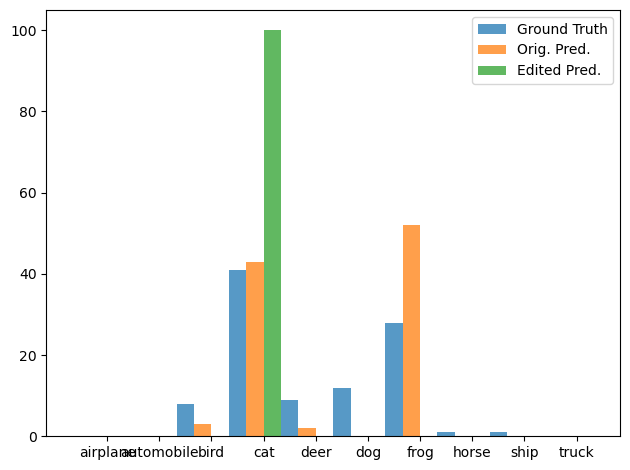

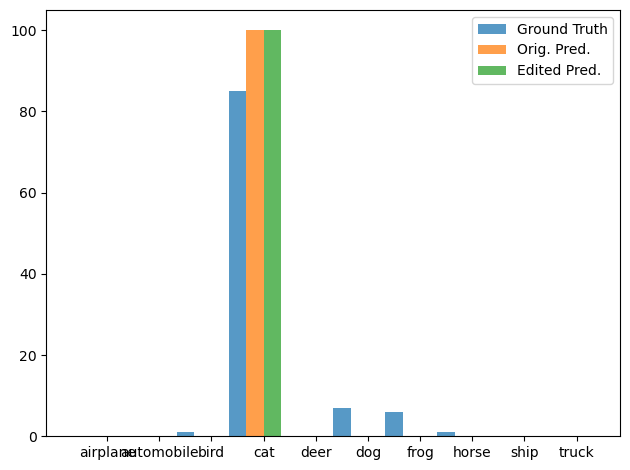

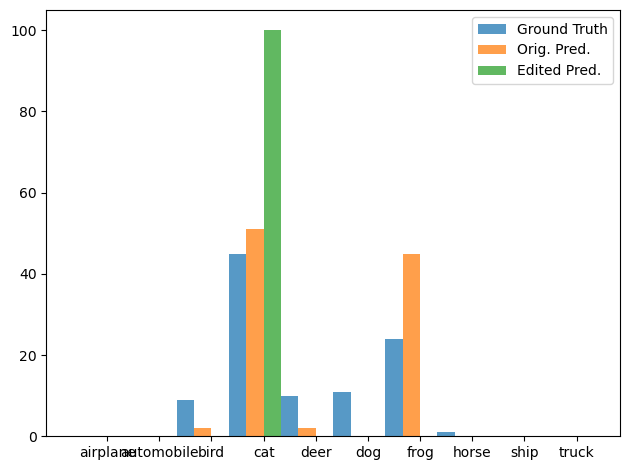

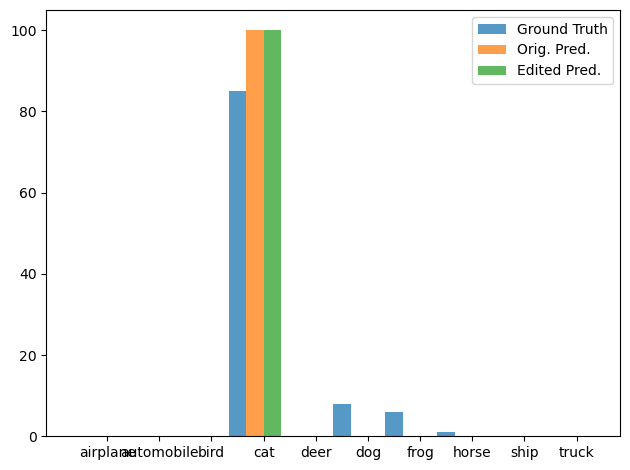

Saved KNN analysis results to saved/edit/trials/CINIC10_ImageNet-VGG_16/0120_155829/results/cat-train-n02128925_31996/slic_masked_logits/models/knn_analysis_results.pth

All metrics and KNN results can be found in saved/edit/trials/CINIC10_ImageNet-VGG_16/0120_155829/results/cat-train-n02128925_31996/slic_masked_logits/models
Finished trial 98/105. Results saved to saved/edit/trials/CINIC10_ImageNet-VGG_16/0120_155829/results/cat-train-n02128925_31996/slic_masked_logits
(0123_095322) Starting Trial 99/105...
Current run_id: 0120_155829/results/cat-train-n02128925_31996/slic_gaussian_logits
saved/edit/trials/CINIC10_ImageNet-VGG_16/0120_155829/results/cat-train-n02128925_31996/slic_gaussian_logits
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: data/cinic-10-imagenet/train/cat/n02128925_31996.png


100%|█████████████████████████████████████████| 274/274 [00:10<00:00, 27.01it/s]


Pre-edit metrics: {'TP': array([6142, 5382, 5203, 3842, 4270, 2990, 5659, 5136, 4820, 4679]), 'TN': array([60115, 61110, 59441, 59902, 60157, 61756, 61050, 61747, 61643,
       61202]), 'FPs': array([2885, 1890, 3559, 3098, 2843, 1244, 1950, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1797, 3158, 2730, 4010, 1341, 1864, 2180, 2321]), 'accuracy': 0.6874714285714286, 'per_class_accuracy': array([0.94652857, 0.94988571, 0.92348571, 0.91062857, 0.92038571,
       0.92494286, 0.95298571, 0.95547143, 0.94947143, 0.94115714]), 'per_class_accuracy_mean': 0.9374942857142857, 'precision': array([0.68040323, 0.74009901, 0.5938142 , 0.55360231, 0.60030929,
       0.706188  , 0.74372454, 0.80388167, 0.78031407, 0.72240235]), 'precision_mean': 0.6924738665961387, 'recall': array([0.87742857, 0.76885714, 0.74328571, 0.54885714, 0.61      ,
       0.42714286, 0.80842857, 0.73371429, 0.68857143, 0.66842857]), 'recall_mean': 0.6874714285714286, 'predicted_class_distribution': array([9027, 7272, 8762, 

tensor(0.0050, device='cuda:0', grad_fn=<DivBackward0>): 100%|█| 40000/40000 [00

Loss (orig, final): 0.0729190930724144 0.0050375680439174175
L2 norm of weight change: 0.3366726040840149
Performing post-edit metric & KNN calculations on validation set.



100%|█████████████████████████████████████████| 274/274 [00:10<00:00, 26.39it/s]


Post-edit metrics: {'TP': array([6157, 5340, 4536, 4818, 3666, 3051, 5732, 4986, 4745, 4785]), 'TN': array([60207, 61170, 61157, 56521, 61433, 61538, 60922, 61979, 61794,
       61095]), 'FPs': array([2793, 1830, 1843, 6479, 1567, 1462, 2078, 1021, 1206, 1905]), 'FNs': array([ 843, 1660, 2464, 2182, 3334, 3949, 1268, 2014, 2255, 2215]), 'accuracy': 0.6830857142857143, 'per_class_accuracy': array([0.94805714, 0.95014286, 0.93847143, 0.87627143, 0.92998571,
       0.9227    , 0.9522    , 0.95664286, 0.95055714, 0.94114286]), 'per_class_accuracy_mean': 0.9366171428571428, 'precision': array([0.68793296, 0.74476987, 0.71108324, 0.42648491, 0.70055418,
       0.67604698, 0.73393086, 0.83003163, 0.79734498, 0.71524664]), 'precision_mean': 0.7023426244032815, 'recall': array([0.87957143, 0.76285714, 0.648     , 0.68828571, 0.52371429,
       0.43585714, 0.81885714, 0.71228571, 0.67785714, 0.68357143]), 'recall_mean': 0.6830857142857142, 'predicted_class_distribution': array([ 8950,  7170,  63

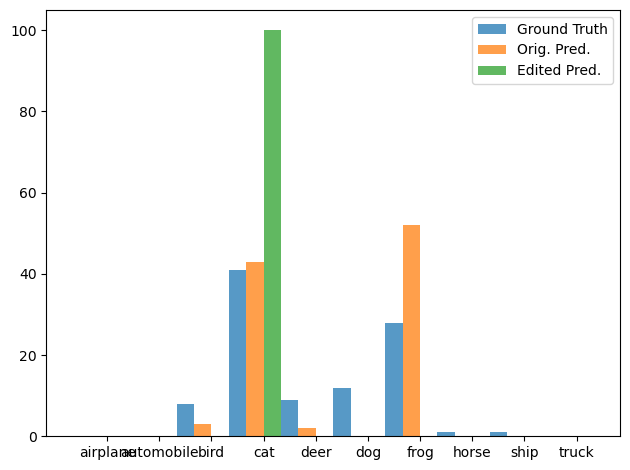

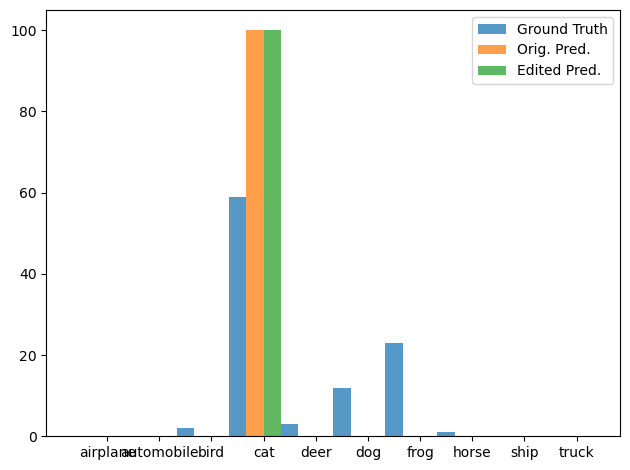

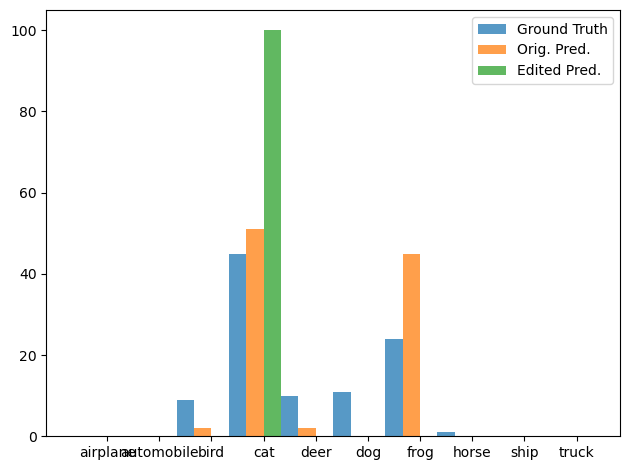

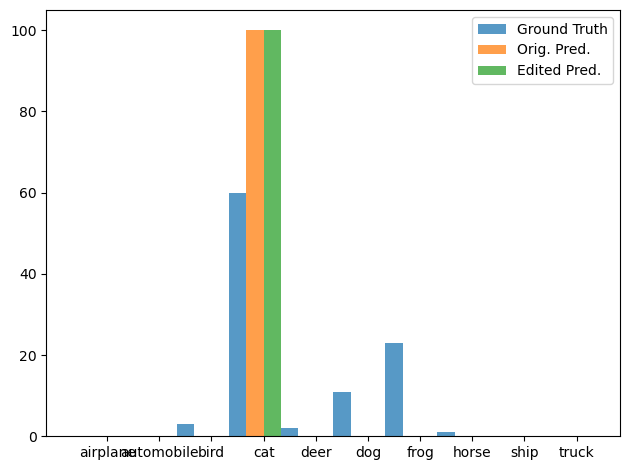

Saved KNN analysis results to saved/edit/trials/CINIC10_ImageNet-VGG_16/0120_155829/results/cat-train-n02128925_31996/slic_gaussian_logits/models/knn_analysis_results.pth

All metrics and KNN results can be found in saved/edit/trials/CINIC10_ImageNet-VGG_16/0120_155829/results/cat-train-n02128925_31996/slic_gaussian_logits/models
Finished trial 99/105. Results saved to saved/edit/trials/CINIC10_ImageNet-VGG_16/0120_155829/results/cat-train-n02128925_31996/slic_gaussian_logits
(0123_095428) Starting Trial 100/105...
Current run_id: 0120_155829/results/cat-train-n02128925_31996/watershed_masked_logits
saved/edit/trials/CINIC10_ImageNet-VGG_16/0120_155829/results/cat-train-n02128925_31996/watershed_masked_logits
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: data/cinic-10-imagenet/train/cat/n021289

100%|█████████████████████████████████████████| 274/274 [00:09<00:00, 29.31it/s]


Pre-edit metrics: {'TP': array([6142, 5382, 5203, 3842, 4270, 2990, 5659, 5136, 4820, 4679]), 'TN': array([60115, 61110, 59441, 59902, 60157, 61756, 61050, 61747, 61643,
       61202]), 'FPs': array([2885, 1890, 3559, 3098, 2843, 1244, 1950, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1797, 3158, 2730, 4010, 1341, 1864, 2180, 2321]), 'accuracy': 0.6874714285714286, 'per_class_accuracy': array([0.94652857, 0.94988571, 0.92348571, 0.91062857, 0.92038571,
       0.92494286, 0.95298571, 0.95547143, 0.94947143, 0.94115714]), 'per_class_accuracy_mean': 0.9374942857142857, 'precision': array([0.68040323, 0.74009901, 0.5938142 , 0.55360231, 0.60030929,
       0.706188  , 0.74372454, 0.80388167, 0.78031407, 0.72240235]), 'precision_mean': 0.6924738665961387, 'recall': array([0.87742857, 0.76885714, 0.74328571, 0.54885714, 0.61      ,
       0.42714286, 0.80842857, 0.73371429, 0.68857143, 0.66842857]), 'recall_mean': 0.6874714285714286, 'predicted_class_distribution': array([9027, 7272, 8762, 

tensor(0.0058, device='cuda:0', grad_fn=<DivBackward0>): 100%|█| 40000/40000 [00

Loss (orig, final): 0.13679549098014832 0.005827121902257204
L2 norm of weight change: 0.5691675543785095
Performing post-edit metric & KNN calculations on validation set.



100%|█████████████████████████████████████████| 274/274 [00:10<00:00, 25.73it/s]
/n/fs/ac-editing/model-editing/src/model/metric.py:168: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(TPs / (TPs + FPs))
/n/fs/ac-editing/model-editing/src/model/metric.py:205: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(2 * precisions * recalls / (precisions + recalls))


Post-edit metrics: {'TP': array([6247, 5073, 4008, 6192, 2139, 2836,    0, 5017, 4575, 4878]), 'TN': array([59825, 61561, 62016, 44962, 62722, 61854, 63000, 61960, 61990,
       61075]), 'FPs': array([ 3175,  1439,   984, 18038,   278,  1146,     0,  1040,  1010,
        1925]), 'FNs': array([ 753, 1927, 2992,  808, 4861, 4164, 7000, 1983, 2425, 2122]), 'accuracy': 0.5852142857142857, 'per_class_accuracy': array([0.94388571, 0.95191429, 0.9432    , 0.73077143, 0.92658571,
       0.92414286, 0.9       , 0.95681429, 0.95092857, 0.94218571]), 'per_class_accuracy_mean': 0.9170428571428572, 'precision': array([0.66302271, 0.77902334, 0.80288462, 0.25555097, 0.88498138,
       0.71220492, 0.        , 0.82829784, 0.81915846, 0.7170366 ]), 'precision_mean': 0.6462160842481508, 'recall': array([0.89242857, 0.72471429, 0.57257143, 0.88457143, 0.30557143,
       0.40514286, 0.        , 0.71671429, 0.65357143, 0.69685714]), 'recall_mean': 0.5852142857142857, 'predicted_class_distribution': array([

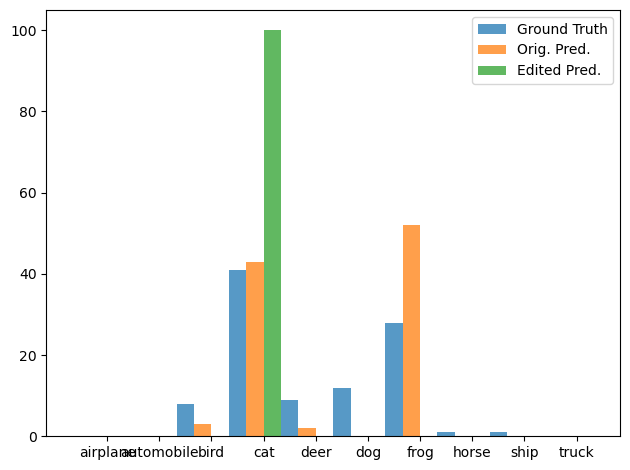

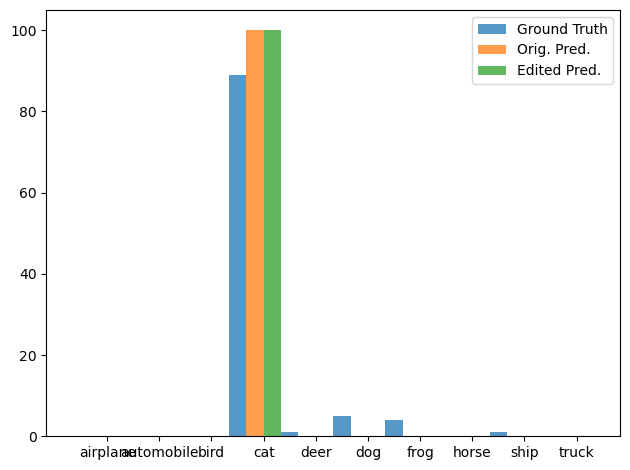

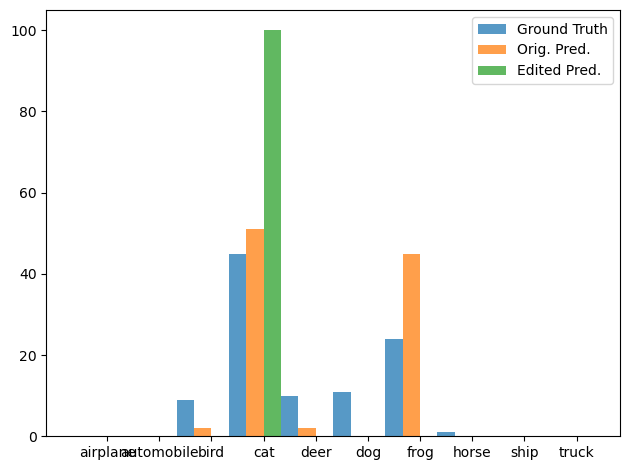

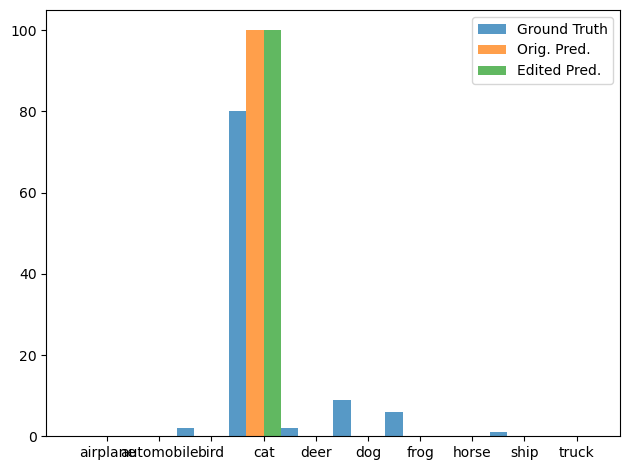

Saved KNN analysis results to saved/edit/trials/CINIC10_ImageNet-VGG_16/0120_155829/results/cat-train-n02128925_31996/watershed_masked_logits/models/knn_analysis_results.pth

All metrics and KNN results can be found in saved/edit/trials/CINIC10_ImageNet-VGG_16/0120_155829/results/cat-train-n02128925_31996/watershed_masked_logits/models
Finished trial 100/105. Results saved to saved/edit/trials/CINIC10_ImageNet-VGG_16/0120_155829/results/cat-train-n02128925_31996/watershed_masked_logits
(0123_095536) Starting Trial 101/105...
Current run_id: 0120_155829/results/cat-train-n02128925_31996/watershed_gaussian_logits
saved/edit/trials/CINIC10_ImageNet-VGG_16/0120_155829/results/cat-train-n02128925_31996/watershed_gaussian_logits
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: data/cinic-10-imagenet/tra

100%|█████████████████████████████████████████| 274/274 [00:08<00:00, 31.55it/s]


Pre-edit metrics: {'TP': array([6142, 5382, 5203, 3842, 4270, 2990, 5659, 5136, 4820, 4679]), 'TN': array([60115, 61110, 59441, 59902, 60157, 61756, 61050, 61747, 61643,
       61202]), 'FPs': array([2885, 1890, 3559, 3098, 2843, 1244, 1950, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1797, 3158, 2730, 4010, 1341, 1864, 2180, 2321]), 'accuracy': 0.6874714285714286, 'per_class_accuracy': array([0.94652857, 0.94988571, 0.92348571, 0.91062857, 0.92038571,
       0.92494286, 0.95298571, 0.95547143, 0.94947143, 0.94115714]), 'per_class_accuracy_mean': 0.9374942857142857, 'precision': array([0.68040323, 0.74009901, 0.5938142 , 0.55360231, 0.60030929,
       0.706188  , 0.74372454, 0.80388167, 0.78031407, 0.72240235]), 'precision_mean': 0.6924738665961387, 'recall': array([0.87742857, 0.76885714, 0.74328571, 0.54885714, 0.61      ,
       0.42714286, 0.80842857, 0.73371429, 0.68857143, 0.66842857]), 'recall_mean': 0.6874714285714286, 'predicted_class_distribution': array([9027, 7272, 8762, 

tensor(0.0040, device='cuda:0', grad_fn=<DivBackward0>): 100%|█| 40000/40000 [00

Loss (orig, final): 0.0522705614566803 0.003999163396656513
L2 norm of weight change: 0.1999264508485794
Performing post-edit metric & KNN calculations on validation set.



100%|█████████████████████████████████████████| 274/274 [00:10<00:00, 27.35it/s]


Post-edit metrics: {'TP': array([6166, 5294, 4743, 4243, 4522, 2973, 5524, 5091, 4877, 4717]), 'TN': array([60060, 61275, 60701, 58914, 59402, 61733, 61450, 61793, 61607,
       61215]), 'FPs': array([2940, 1725, 2299, 4086, 3598, 1267, 1550, 1207, 1393, 1785]), 'FNs': array([ 834, 1706, 2257, 2757, 2478, 4027, 1476, 1909, 2123, 2283]), 'accuracy': 0.6878571428571428, 'per_class_accuracy': array([0.94608571, 0.95098571, 0.93491429, 0.90224286, 0.9132    ,
       0.92437143, 0.95677143, 0.95548571, 0.94977143, 0.94188571]), 'per_class_accuracy_mean': 0.9375714285714286, 'precision': array([0.67713595, 0.7542385 , 0.67353025, 0.5094249 , 0.55689655,
       0.70117925, 0.78088776, 0.80835186, 0.77783094, 0.72546909]), 'precision_mean': 0.6964945038015948, 'recall': array([0.88085714, 0.75628571, 0.67757143, 0.60614286, 0.646     ,
       0.42471429, 0.78914286, 0.72728571, 0.69671429, 0.67385714]), 'recall_mean': 0.687857142857143, 'predicted_class_distribution': array([9106, 7019, 7042, 

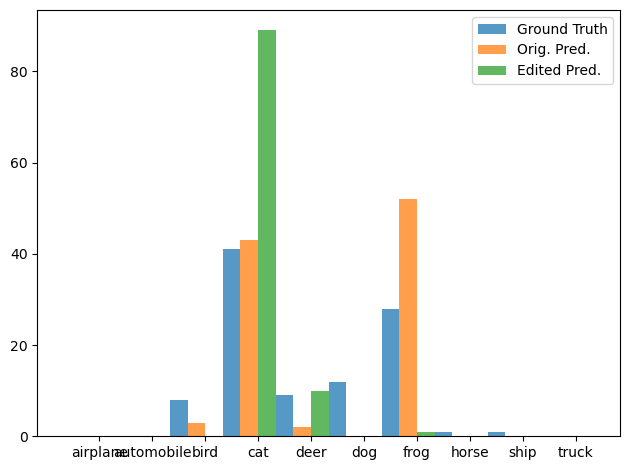

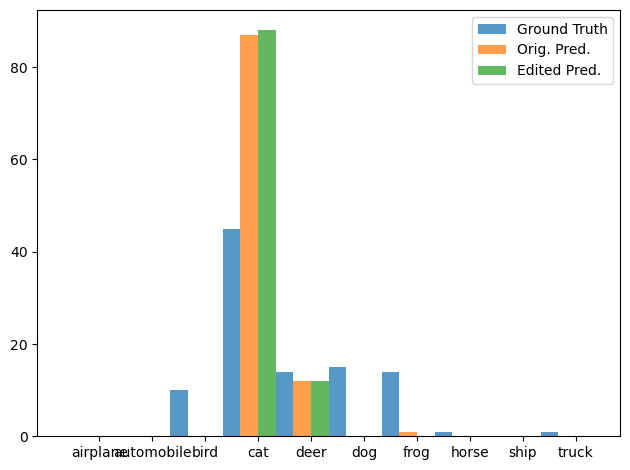

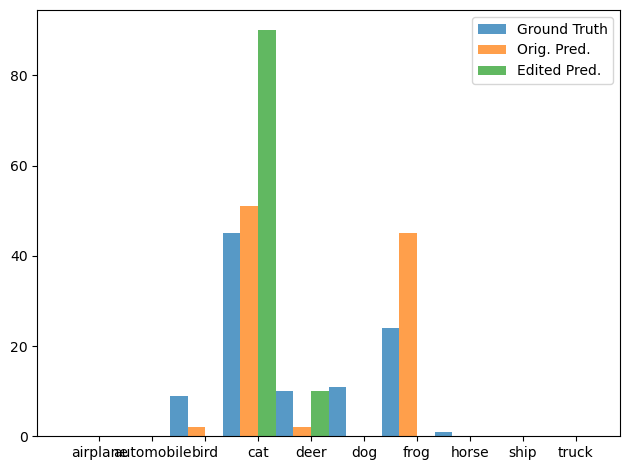

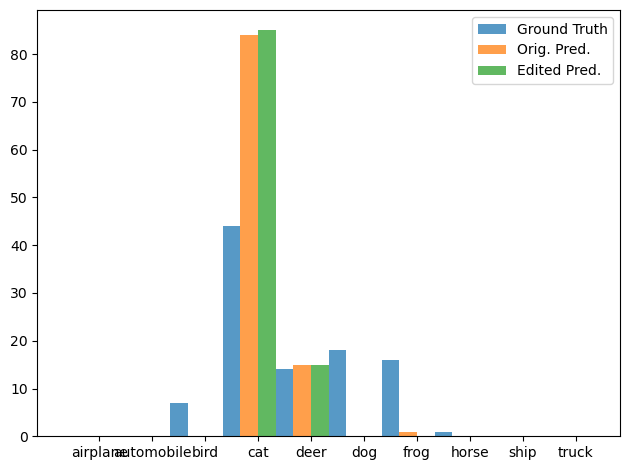

Saved KNN analysis results to saved/edit/trials/CINIC10_ImageNet-VGG_16/0120_155829/results/cat-train-n02128925_31996/watershed_gaussian_logits/models/knn_analysis_results.pth

All metrics and KNN results can be found in saved/edit/trials/CINIC10_ImageNet-VGG_16/0120_155829/results/cat-train-n02128925_31996/watershed_gaussian_logits/models
Finished trial 101/105. Results saved to saved/edit/trials/CINIC10_ImageNet-VGG_16/0120_155829/results/cat-train-n02128925_31996/watershed_gaussian_logits
(0123_095641) Starting Trial 102/105...
Current run_id: 0120_155829/results/cat-train-n02126640_2044/felzenszwalb_masked_logits
saved/edit/trials/CINIC10_ImageNet-VGG_16/0120_155829/results/cat-train-n02126640_2044/felzenszwalb_masked_logits
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: data/cinic-10-imagen

100%|█████████████████████████████████████████| 274/274 [00:08<00:00, 31.38it/s]


Pre-edit metrics: {'TP': array([6142, 5382, 5203, 3842, 4270, 2990, 5659, 5136, 4820, 4679]), 'TN': array([60115, 61110, 59441, 59902, 60157, 61756, 61050, 61747, 61643,
       61202]), 'FPs': array([2885, 1890, 3559, 3098, 2843, 1244, 1950, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1797, 3158, 2730, 4010, 1341, 1864, 2180, 2321]), 'accuracy': 0.6874714285714286, 'per_class_accuracy': array([0.94652857, 0.94988571, 0.92348571, 0.91062857, 0.92038571,
       0.92494286, 0.95298571, 0.95547143, 0.94947143, 0.94115714]), 'per_class_accuracy_mean': 0.9374942857142857, 'precision': array([0.68040323, 0.74009901, 0.5938142 , 0.55360231, 0.60030929,
       0.706188  , 0.74372454, 0.80388167, 0.78031407, 0.72240235]), 'precision_mean': 0.6924738665961387, 'recall': array([0.87742857, 0.76885714, 0.74328571, 0.54885714, 0.61      ,
       0.42714286, 0.80842857, 0.73371429, 0.68857143, 0.66842857]), 'recall_mean': 0.6874714285714286, 'predicted_class_distribution': array([9027, 7272, 8762, 

tensor(0.0371, device='cuda:0', grad_fn=<DivBackward0>): 100%|█| 40000/40000 [00

Loss (orig, final): 0.19872137904167175 0.037143416702747345
L2 norm of weight change: 0.6495238542556763
Performing post-edit metric & KNN calculations on validation set.



100%|█████████████████████████████████████████| 274/274 [00:09<00:00, 27.78it/s]
/n/fs/ac-editing/model-editing/src/model/metric.py:168: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(TPs / (TPs + FPs))
/n/fs/ac-editing/model-editing/src/model/metric.py:205: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(2 * precisions * recalls / (precisions + recalls))


Post-edit metrics: {'TP': array([6164, 4896,    0, 5952, 3758, 2759,    0, 5020, 4690, 4893]), 'TN': array([60158, 61742, 63000, 42136, 61178, 62001, 63000, 61960, 61816,
       61141]), 'FPs': array([ 2842,  1258,     0, 20864,  1822,   999,     0,  1040,  1184,
        1859]), 'FNs': array([ 836, 2104, 7000, 1048, 3242, 4241, 7000, 1980, 2310, 2107]), 'accuracy': 0.5447428571428572, 'per_class_accuracy': array([0.94745714, 0.95197143, 0.9       , 0.68697143, 0.92765714,
       0.92514286, 0.9       , 0.95685714, 0.95008571, 0.94334286]), 'per_class_accuracy_mean': 0.9089485714285714, 'precision': array([0.6844326 , 0.79558011, 0.        , 0.22195704, 0.6734767 ,
       0.73416711, 0.        , 0.82838284, 0.79843378, 0.72467417]), 'precision_mean': 0.5461104349094342, 'recall': array([0.88057143, 0.69942857, 0.        , 0.85028571, 0.53685714,
       0.39414286, 0.        , 0.71714286, 0.67      , 0.699     ]), 'recall_mean': 0.5447428571428572, 'predicted_class_distribution': array([

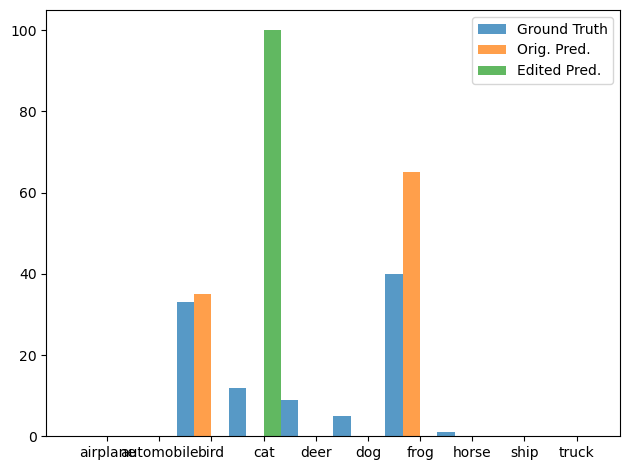

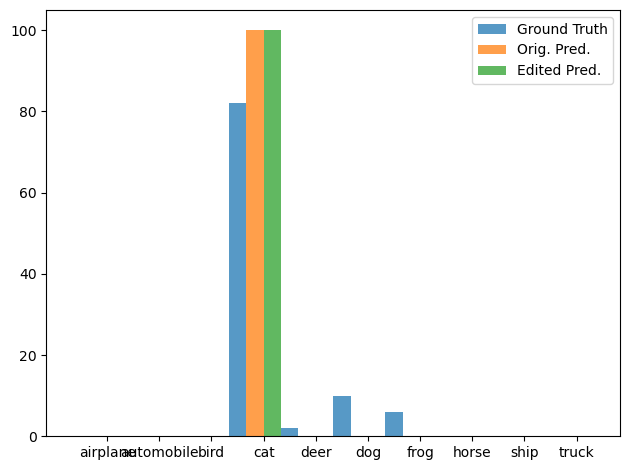

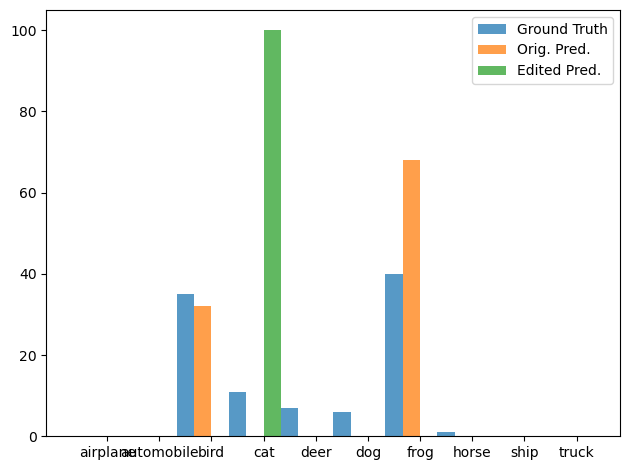

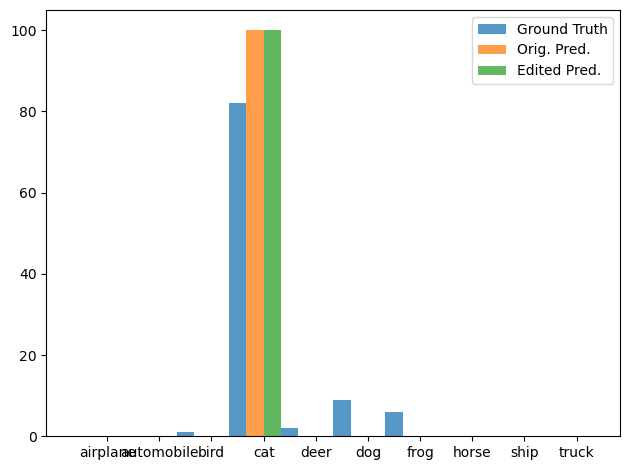

Saved KNN analysis results to saved/edit/trials/CINIC10_ImageNet-VGG_16/0120_155829/results/cat-train-n02126640_2044/felzenszwalb_masked_logits/models/knn_analysis_results.pth

All metrics and KNN results can be found in saved/edit/trials/CINIC10_ImageNet-VGG_16/0120_155829/results/cat-train-n02126640_2044/felzenszwalb_masked_logits/models
Finished trial 102/105. Results saved to saved/edit/trials/CINIC10_ImageNet-VGG_16/0120_155829/results/cat-train-n02126640_2044/felzenszwalb_masked_logits
(0123_095746) Starting Trial 103/105...
Current run_id: 0120_155829/results/cat-train-n02126640_2044/quickshift_masked_logits
saved/edit/trials/CINIC10_ImageNet-VGG_16/0120_155829/results/cat-train-n02126640_2044/quickshift_masked_logits
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: data/cinic-10-imagenet/t

100%|█████████████████████████████████████████| 274/274 [00:09<00:00, 30.44it/s]


Pre-edit metrics: {'TP': array([6142, 5382, 5203, 3842, 4270, 2990, 5659, 5136, 4820, 4679]), 'TN': array([60115, 61110, 59441, 59902, 60157, 61756, 61050, 61747, 61643,
       61202]), 'FPs': array([2885, 1890, 3559, 3098, 2843, 1244, 1950, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1797, 3158, 2730, 4010, 1341, 1864, 2180, 2321]), 'accuracy': 0.6874714285714286, 'per_class_accuracy': array([0.94652857, 0.94988571, 0.92348571, 0.91062857, 0.92038571,
       0.92494286, 0.95298571, 0.95547143, 0.94947143, 0.94115714]), 'per_class_accuracy_mean': 0.9374942857142857, 'precision': array([0.68040323, 0.74009901, 0.5938142 , 0.55360231, 0.60030929,
       0.706188  , 0.74372454, 0.80388167, 0.78031407, 0.72240235]), 'precision_mean': 0.6924738665961387, 'recall': array([0.87742857, 0.76885714, 0.74328571, 0.54885714, 0.61      ,
       0.42714286, 0.80842857, 0.73371429, 0.68857143, 0.66842857]), 'recall_mean': 0.6874714285714286, 'predicted_class_distribution': array([9027, 7272, 8762, 

tensor(0.0341, device='cuda:0', grad_fn=<DivBackward0>): 100%|█| 40000/40000 [00

Loss (orig, final): 0.15315906703472137 0.034110233187675476
L2 norm of weight change: 0.4434081017971039
Performing post-edit metric & KNN calculations on validation set.



100%|█████████████████████████████████████████| 274/274 [00:09<00:00, 29.47it/s]


Post-edit metrics: {'TP': array([6252, 5263, 4163, 4793, 4346, 3040, 4404, 5101, 5063, 4741]), 'TN': array([59218, 61324, 61731, 56685, 59803, 61641, 62627, 61778, 61242,
       61117]), 'FPs': array([3782, 1676, 1269, 6315, 3197, 1359,  373, 1222, 1758, 1883]), 'FNs': array([ 748, 1737, 2837, 2207, 2654, 3960, 2596, 1899, 1937, 2259]), 'accuracy': 0.6738, 'per_class_accuracy': array([0.93528571, 0.95124286, 0.94134286, 0.87825714, 0.91641429,
       0.92401429, 0.95758571, 0.95541429, 0.94721429, 0.94082857]), 'per_class_accuracy_mean': 0.93476, 'precision': array([0.62308152, 0.75846664, 0.76638439, 0.43149082, 0.57616333,
       0.69106615, 0.92191752, 0.80673731, 0.74226653, 0.71573068]), 'precision_mean': 0.7033304884400005, 'recall': array([0.89314286, 0.75185714, 0.59471429, 0.68471429, 0.62085714,
       0.43428571, 0.62914286, 0.72871429, 0.72328571, 0.67728571]), 'recall_mean': 0.6738, 'predicted_class_distribution': array([10034,  6939,  5432, 11108,  7543,  4399,  4777,  63

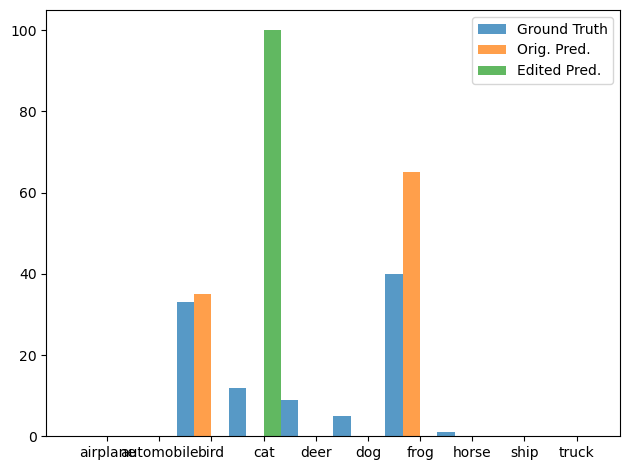

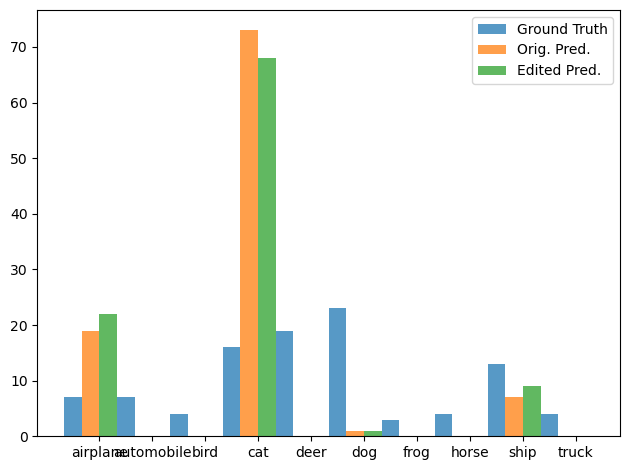

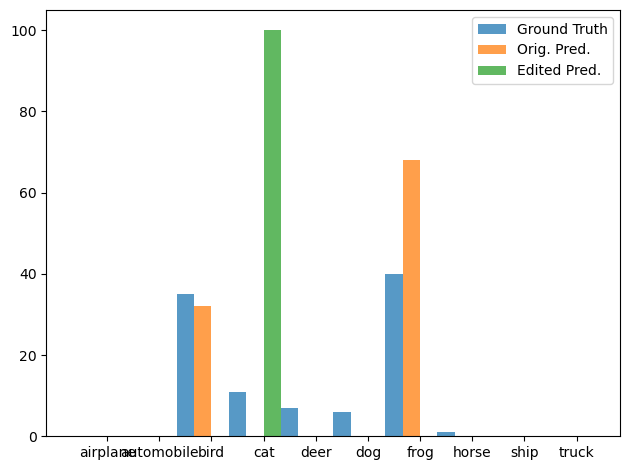

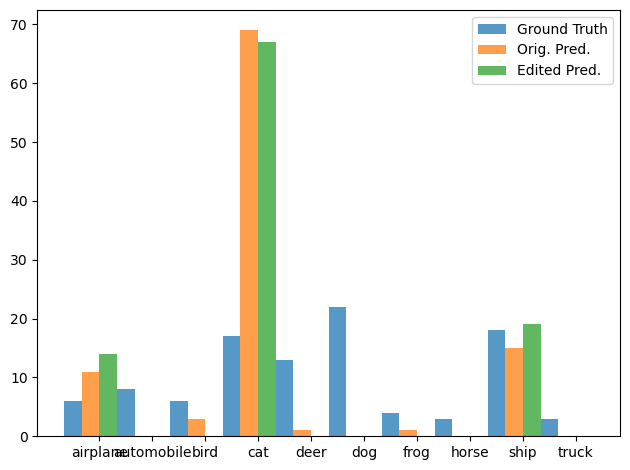

Saved KNN analysis results to saved/edit/trials/CINIC10_ImageNet-VGG_16/0120_155829/results/cat-train-n02126640_2044/quickshift_masked_logits/models/knn_analysis_results.pth

All metrics and KNN results can be found in saved/edit/trials/CINIC10_ImageNet-VGG_16/0120_155829/results/cat-train-n02126640_2044/quickshift_masked_logits/models
Finished trial 103/105. Results saved to saved/edit/trials/CINIC10_ImageNet-VGG_16/0120_155829/results/cat-train-n02126640_2044/quickshift_masked_logits
(0123_095850) Starting Trial 104/105...
Current run_id: 0120_155829/results/cat-train-n02126640_2044/slic_masked_logits
saved/edit/trials/CINIC10_ImageNet-VGG_16/0120_155829/results/cat-train-n02126640_2044/slic_masked_logits
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: data/cinic-10-imagenet/train/cat/n02126640

100%|█████████████████████████████████████████| 274/274 [00:08<00:00, 31.07it/s]


Pre-edit metrics: {'TP': array([6142, 5382, 5203, 3842, 4270, 2990, 5659, 5136, 4820, 4679]), 'TN': array([60115, 61110, 59441, 59902, 60157, 61756, 61050, 61747, 61643,
       61202]), 'FPs': array([2885, 1890, 3559, 3098, 2843, 1244, 1950, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1797, 3158, 2730, 4010, 1341, 1864, 2180, 2321]), 'accuracy': 0.6874714285714286, 'per_class_accuracy': array([0.94652857, 0.94988571, 0.92348571, 0.91062857, 0.92038571,
       0.92494286, 0.95298571, 0.95547143, 0.94947143, 0.94115714]), 'per_class_accuracy_mean': 0.9374942857142857, 'precision': array([0.68040323, 0.74009901, 0.5938142 , 0.55360231, 0.60030929,
       0.706188  , 0.74372454, 0.80388167, 0.78031407, 0.72240235]), 'precision_mean': 0.6924738665961387, 'recall': array([0.87742857, 0.76885714, 0.74328571, 0.54885714, 0.61      ,
       0.42714286, 0.80842857, 0.73371429, 0.68857143, 0.66842857]), 'recall_mean': 0.6874714285714286, 'predicted_class_distribution': array([9027, 7272, 8762, 

tensor(0.0341, device='cuda:0', grad_fn=<DivBackward0>): 100%|█| 40000/40000 [00

Loss (orig, final): 0.15315906703472137 0.034110233187675476
L2 norm of weight change: 0.4434081017971039
Performing post-edit metric & KNN calculations on validation set.



100%|█████████████████████████████████████████| 274/274 [00:09<00:00, 28.47it/s]


Post-edit metrics: {'TP': array([6252, 5263, 4163, 4793, 4346, 3040, 4404, 5101, 5063, 4741]), 'TN': array([59218, 61324, 61731, 56685, 59803, 61641, 62627, 61778, 61242,
       61117]), 'FPs': array([3782, 1676, 1269, 6315, 3197, 1359,  373, 1222, 1758, 1883]), 'FNs': array([ 748, 1737, 2837, 2207, 2654, 3960, 2596, 1899, 1937, 2259]), 'accuracy': 0.6738, 'per_class_accuracy': array([0.93528571, 0.95124286, 0.94134286, 0.87825714, 0.91641429,
       0.92401429, 0.95758571, 0.95541429, 0.94721429, 0.94082857]), 'per_class_accuracy_mean': 0.93476, 'precision': array([0.62308152, 0.75846664, 0.76638439, 0.43149082, 0.57616333,
       0.69106615, 0.92191752, 0.80673731, 0.74226653, 0.71573068]), 'precision_mean': 0.7033304884400005, 'recall': array([0.89314286, 0.75185714, 0.59471429, 0.68471429, 0.62085714,
       0.43428571, 0.62914286, 0.72871429, 0.72328571, 0.67728571]), 'recall_mean': 0.6738, 'predicted_class_distribution': array([10034,  6939,  5432, 11108,  7543,  4399,  4777,  63

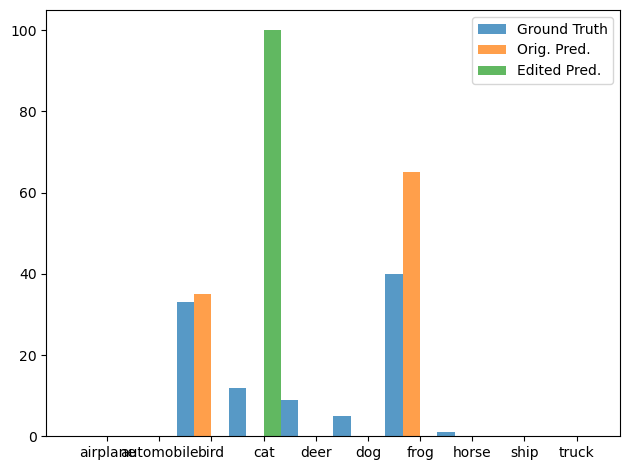

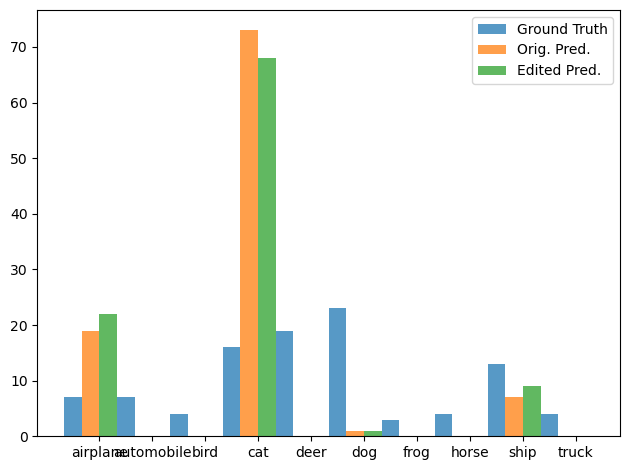

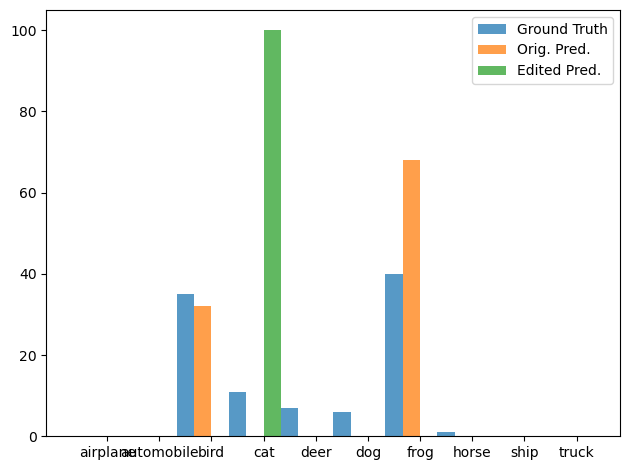

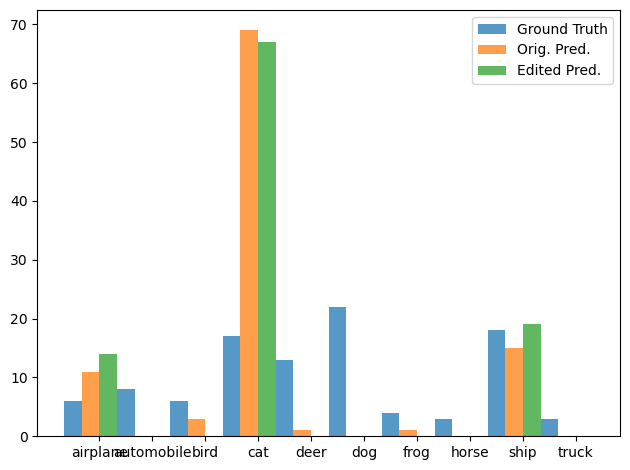

Saved KNN analysis results to saved/edit/trials/CINIC10_ImageNet-VGG_16/0120_155829/results/cat-train-n02126640_2044/slic_masked_logits/models/knn_analysis_results.pth

All metrics and KNN results can be found in saved/edit/trials/CINIC10_ImageNet-VGG_16/0120_155829/results/cat-train-n02126640_2044/slic_masked_logits/models
Finished trial 104/105. Results saved to saved/edit/trials/CINIC10_ImageNet-VGG_16/0120_155829/results/cat-train-n02126640_2044/slic_masked_logits
(0123_095955) Starting Trial 105/105...
Current run_id: 0120_155829/results/cat-train-n02126640_2044/watershed_masked_logits
saved/edit/trials/CINIC10_ImageNet-VGG_16/0120_155829/results/cat-train-n02126640_2044/watershed_masked_logits
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: data/cinic-10-imagenet/train/cat/n02126640_2044.pn

100%|█████████████████████████████████████████| 274/274 [00:08<00:00, 31.41it/s]


Pre-edit metrics: {'TP': array([6142, 5382, 5203, 3842, 4270, 2990, 5659, 5136, 4820, 4679]), 'TN': array([60115, 61110, 59441, 59902, 60157, 61756, 61050, 61747, 61643,
       61202]), 'FPs': array([2885, 1890, 3559, 3098, 2843, 1244, 1950, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1797, 3158, 2730, 4010, 1341, 1864, 2180, 2321]), 'accuracy': 0.6874714285714286, 'per_class_accuracy': array([0.94652857, 0.94988571, 0.92348571, 0.91062857, 0.92038571,
       0.92494286, 0.95298571, 0.95547143, 0.94947143, 0.94115714]), 'per_class_accuracy_mean': 0.9374942857142857, 'precision': array([0.68040323, 0.74009901, 0.5938142 , 0.55360231, 0.60030929,
       0.706188  , 0.74372454, 0.80388167, 0.78031407, 0.72240235]), 'precision_mean': 0.6924738665961387, 'recall': array([0.87742857, 0.76885714, 0.74328571, 0.54885714, 0.61      ,
       0.42714286, 0.80842857, 0.73371429, 0.68857143, 0.66842857]), 'recall_mean': 0.6874714285714286, 'predicted_class_distribution': array([9027, 7272, 8762, 

tensor(0.0221, device='cuda:0', grad_fn=<DivBackward0>): 100%|█| 40000/40000 [00

Loss (orig, final): 0.11025981605052948 0.022096335887908936
L2 norm of weight change: 0.31625786423683167
Performing post-edit metric & KNN calculations on validation set.



100%|█████████████████████████████████████████| 274/274 [00:10<00:00, 26.84it/s]


Post-edit metrics: {'TP': array([6207, 5240, 4507, 4751, 4161, 2899, 5283, 5159, 4755, 4840]), 'TN': array([59852, 61349, 61225, 56805, 60366, 61812, 61879, 61713, 61762,
       61039]), 'FPs': array([3148, 1651, 1775, 6195, 2634, 1188, 1121, 1287, 1238, 1961]), 'FNs': array([ 793, 1760, 2493, 2249, 2839, 4101, 1717, 1841, 2245, 2160]), 'accuracy': 0.6828857142857143, 'per_class_accuracy': array([0.9437    , 0.95127143, 0.93902857, 0.87937143, 0.92181429,
       0.92444286, 0.95945714, 0.95531429, 0.95024286, 0.94112857]), 'per_class_accuracy_mean': 0.9365771428571428, 'precision': array([0.66349546, 0.76041213, 0.71744667, 0.43403983, 0.61236203,
       0.70932224, 0.82495315, 0.8003413 , 0.79342566, 0.71166005]), 'precision_mean': 0.7027458530308281, 'recall': array([0.88671429, 0.74857143, 0.64385714, 0.67871429, 0.59442857,
       0.41414286, 0.75471429, 0.737     , 0.67928571, 0.69142857]), 'recall_mean': 0.6828857142857142, 'predicted_class_distribution': array([ 9355,  6891,  62

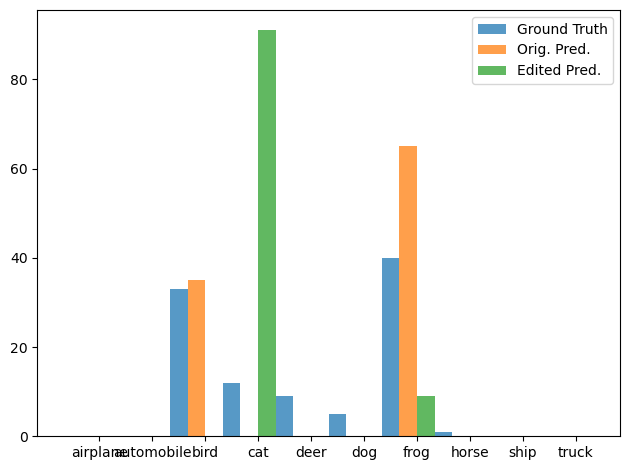

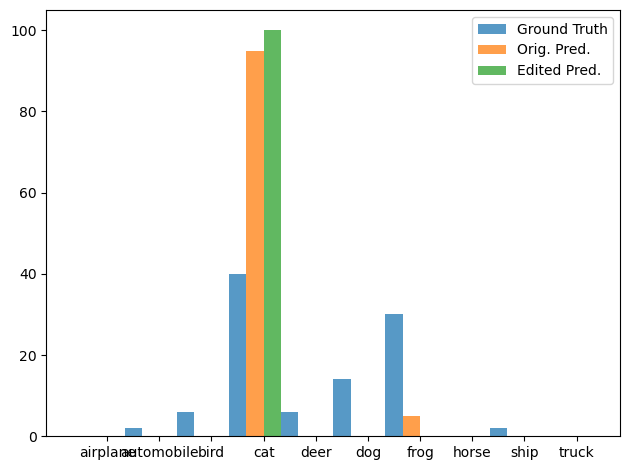

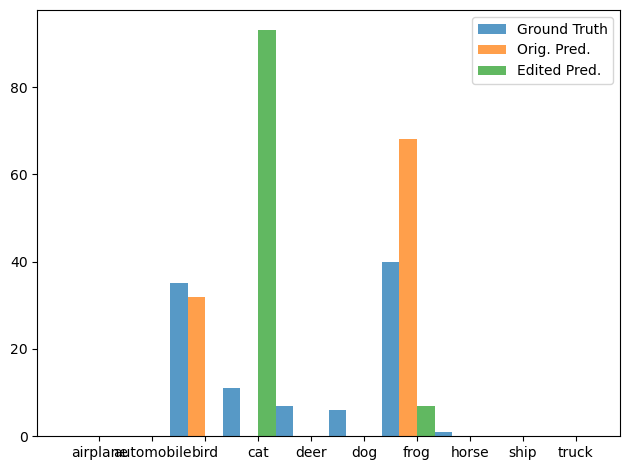

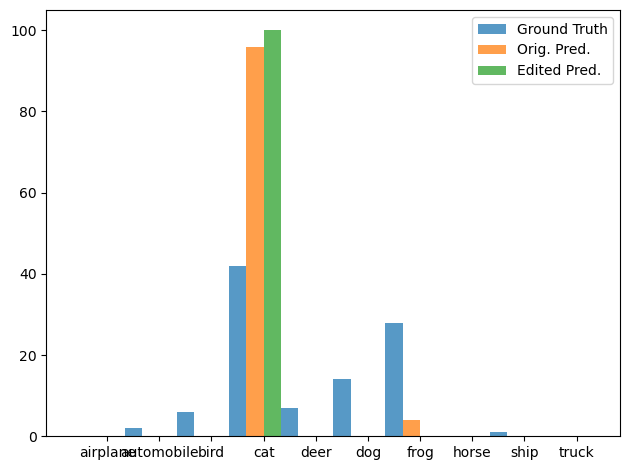

Saved KNN analysis results to saved/edit/trials/CINIC10_ImageNet-VGG_16/0120_155829/results/cat-train-n02126640_2044/watershed_masked_logits/models/knn_analysis_results.pth

All metrics and KNN results can be found in saved/edit/trials/CINIC10_ImageNet-VGG_16/0120_155829/results/cat-train-n02126640_2044/watershed_masked_logits/models
Finished trial 105/105. Results saved to saved/edit/trials/CINIC10_ImageNet-VGG_16/0120_155829/results/cat-train-n02126640_2044/watershed_masked_logits


In [19]:
for idx, (key_path, value_path) in enumerate(zip(key_image_paths, value_image_paths)):
    if idx < 93:
        continue
    split = os.path.basename(os.path.dirname(os.path.dirname(key_path)))
    class_name = os.path.basename(os.path.dirname(key_path))
    file_name = os.path.basename(key_path).split(".")[0]
    key_image_id = "{}-{}-{}".format(class_name, split, file_name)
    # Print Progress
    informal_log("({}) Starting Trial {}/{}...".format(datetime.now().strftime(r'%m%d_%H%M%S'), idx + 1, n_trials), progress_report_path)
    
    # Create run id 
    value_image_id = os.path.splitext(os.path.basename(value_path))[0]
    run_id = os.path.join(timestamp, 'results', key_image_id, value_image_id)
    informal_log("Current run_id: {}".format(run_id), progress_report_path)
    
    # Read config file as json and make updates to key and value paths
    config_dict = read_json(config_path)
    config_dict['editor'].update({
        'key_paths_file': key_path,
        'value_paths_file': value_path
    })
    
    # Create config object
    config = ConfigParser(config_dict, run_id=run_id)
    
    # Log the current trial path
    informal_log(os.path.dirname(config.save_dir), save_trials_path)
    
    informal_log("Calling edit()...", progress_report_path)
    
    edit(
        config=config,
        val_paths_data_loader=val_paths_data_loader,
        covariance_data_loader=covariance_data_loader,
        do_analyze_knn=analyze_in_edit)
    
    # Print progress
    informal_log("Finished trial {}/{}. Results saved to {}".format(idx + 1, n_trials, os.path.dirname(config.save_dir)),
                progress_report_path)


In [43]:
save_trials_path = 'saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/trial_paths.txt'
trial_dirs = read_lists(save_trials_path)
knn_analysis_filename = 'knn_analysis_results.pth'

In [44]:
try:
    if not os.path.exists(save_trials_path):
        print("Path {} does not exist".format(save_trials_path))
    else:
        print("Obtaining trial paths from {}".format(save_trials_path))
except:
    print("Need to define save_trials_path.")



Obtaining trial paths from saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/trial_paths.txt


## Analyze KNN

In [23]:
## Process KNN results for each
n_trials = len(trial_dirs)
n_log = n_trials // 10 + 1  # log every 10%
progress_report_path = os.path.join(os.path.dirname(save_trials_path), 'progress_report_analysis.txt')

informal_log("Starting KNN analysis...", progress_report_path)
for trial_idx, trial_dir in tqdm(enumerate(trial_dirs)):
    # if trial_idx % n_log == 0:
    informal_log("Processing {}/{} trials. Currently processing {}".format(
        trial_idx+1, n_trials, os.path.basename(trial_dir)), progress_report_path)
                     
    results_save_dir = os.path.join(trial_dir, 'models')
    load_and_analyze_knn(
        restore_dir=results_save_dir,
        pre_edit_knn_path=os.path.join(results_save_dir, 'pre_edit_{}-nn.pth'.format(K)),
        post_edit_knn_path=os.path.join(results_save_dir, 'post_edit_{}-nn.pth'.format(K)),
        knn_analysis_filename=knn_analysis_filename,
        target_class_idx=target_class_idx,
        class_list=class_list,
        progress_report_path=progress_report_path,
        save_images=False,
        save_plots=True)
    


Starting KNN analysis...


0it [00:00, ?it/s]

Processing 1/37 trials. Currently processing felzenszwalb_gaussian_0
Analyzing KNN results from saved/edit/trials/CINIC10_ImageNet-VGG_16/0112_121958/dog-train-n02114712_211/felzenszwalb_gaussian_0/models
Logging and saving visualizations to saved/edit/trials/CINIC10_ImageNet-VGG_16/0112_121958/dog-train-n02114712_211/felzenszwalb_gaussian_0/models/knn_visualizations/knn_analysis_log.txt
Saving results to saved/edit/trials/CINIC10_ImageNet-VGG_16/0112_121958/dog-train-n02114712_211/felzenszwalb_gaussian_0/models/knn_analysis_results.pth


0it [00:00, ?it/s]


FileNotFoundError: [Errno 2] No such file or directory: 'saved/edit/trials/CINIC10_ImageNet-VGG_16/0112_121958/dog-train-n02114712_211/felzenszwalb_gaussian_0/models/edited_model.pth'

## Convert to CSV for all trials

In [45]:
data = []
# Iterate through all trials
for trial_idx, trial_dir in tqdm(enumerate(trial_dirs)):
    # Obtain key ID from path
    key_id = os.path.basename(os.path.dirname(trial_dir))
    id_class = key_id.split('-')[0]
    if id_class not in class_list:
        raise ValueError("Invalid key_id {}".format(key_id))
    # Obtain value ID from path
    val_id = os.path.basename(trial_dir)
    # Join to make a data ID
    data_id = os.path.join(key_id, val_id)
    
    # Load results from knn, pre-edit metrics, and post-edit metrics
    restore_dir = os.path.join(trial_dir, 'models')
    knn_analysis_results = torch.load(os.path.join(restore_dir, knn_analysis_filename))
    pre_edit_metrics = torch.load(os.path.join(restore_dir, 'pre_edit_metrics.pth'))
    post_edit_metrics = torch.load(os.path.join(restore_dir, 'post_edit_metrics.pth'))
    
    # Combine results into one dictionary
    combined_results = combine_results(
        data_id=data_id,
        knn_analysis=knn_analysis_results,
        pre_edit_metrics=pre_edit_metrics,
        post_edit_metrics=post_edit_metrics)
    
    # Save column headers in first trial run
    if trial_idx == 0:
        column_headers = list(combined_results.keys())
    # Convert results to np.array & append to list
    combined_results = np.expand_dims(np.array(list(combined_results.values())), axis=0)
    data.append(combined_results)

# Convert data from list of np.arrays -> pd.DataFrame    
data = np.concatenate(data, axis=0)
df = pd.DataFrame(data, columns=column_headers)


2008it [00:16, 120.03it/s]


In [46]:
# Save to CSV
csv_save_path = os.path.join(os.path.dirname(save_trials_path), 'results_table.csv')
df.to_csv(csv_save_path)
print("Saved CSV to {}".format(csv_save_path))

Saved CSV to saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/results_table.csv
